In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
import random
import pandas as pd
import math
from ooppnm import wrap_openpnm as pnm_sim
from eval.models_lib import model1
from os import path

def kr_simulation(img_input):
    data_pnm = pnm_sim.Wrap_pnm(im=img_input)
    data_pnm.network_extract()
    data_pnm.add_boundary_pn()
    data_pnm.init_physics()
    data_pnm.invasion_percolation()
    try:
      df_kr = data_pnm.kr_simulation()
    except Exception as e:
      print(e)
      bad_im.append(img_input)
      return pd.DataFrame()

    data_pnm.close_ws()
    return df_kr

def tensor_process(image_tensor):

    image_unflat = image_tensor.detach().cpu()
    image_numpy = image_unflat.numpy()

    return image_numpy

def img_filter(im):
  return im>0.5

# load the model
torch.manual_seed(0)
ex = 2

import init_yaml
f_yaml = init_yaml.Init_yaml().config
model_path = init_yaml.Init_yaml().path_join(f_yaml['model_path']['model_save'],f'ex{ex}/cgan0620.pth')
feature_path = init_yaml.Init_yaml().path_join(f_yaml['feature_path'],'features.csv')
img_path = init_yaml.Init_yaml().path_join(f_yaml['img_path']['raw_data'])

df = pd.read_csv(feature_path)

gen = model1.Generator(embed_size=6)
gen.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
gen.eval()


bad_im = []

In [ ]:
kr_phi = {}
eul_list = [-100,0,100]
image_num = 5

img_check = {}

for eul in eul_list:

  # initialize inputs for GAN
  z = torch.randn(image_num,100)
  features = torch.full((image_num,1),eul)
  kr_store_i = []
  img_check_list = []


  with torch.no_grad():
    fake = gen(z,features)
    img = tensor_process(fake)
    img = img_filter(img)
    img_check_list.append(img)
  
  for i in range(image_num):
    
    # perform PNM
    # input should be 3D numpy array
    df_kr = kr_simulation(img[i,0,::])
    kr_store_i.append(df_kr)    
      
  
  kr_phi["{:.2f}".format(eul)] = kr_store_i
  img_check["{:.2f}".format(eul)] = img_check_list

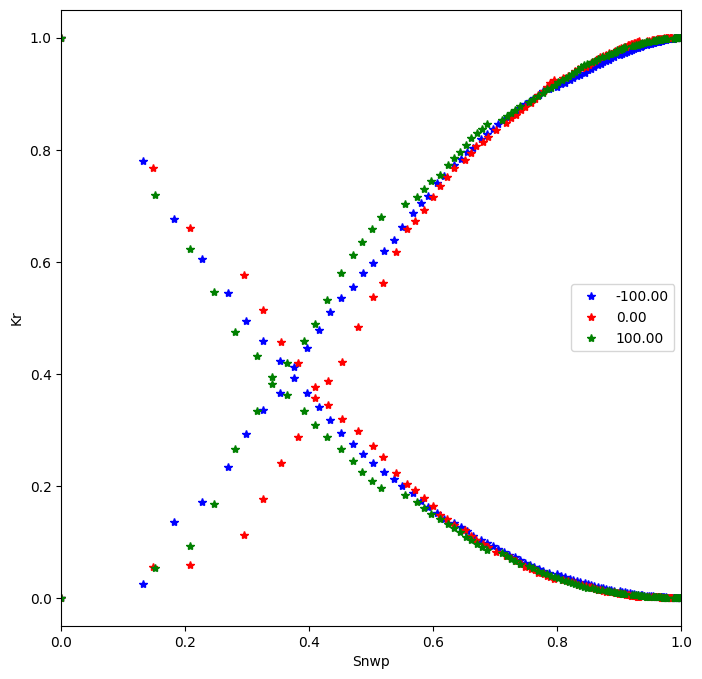

In [3]:
kr_avg = {}
for eul in kr_phi.keys():
  kr_avg[eul] = pd.concat(kr_phi[eul]).groupby(level=0).mean()

f = plt.figure(figsize=[8,8])
c = ['b*','r*','g*']
for eul,i in zip(kr_avg.keys(),c):
  df = kr_avg[eul]
  plt.plot(df['snwp'], df['krnw'], i, label=eul)
  plt.plot(df['snwp'], df['krw'], i)
plt.xlabel('Snwp')
plt.xlim([0,1])
plt.ylabel('Kr')
plt.legend()

In [4]:
kr_phi.keys()

dict_keys(['-100.00', '0.00', '100.00'])

Text(0, 0.5, 'Kr')

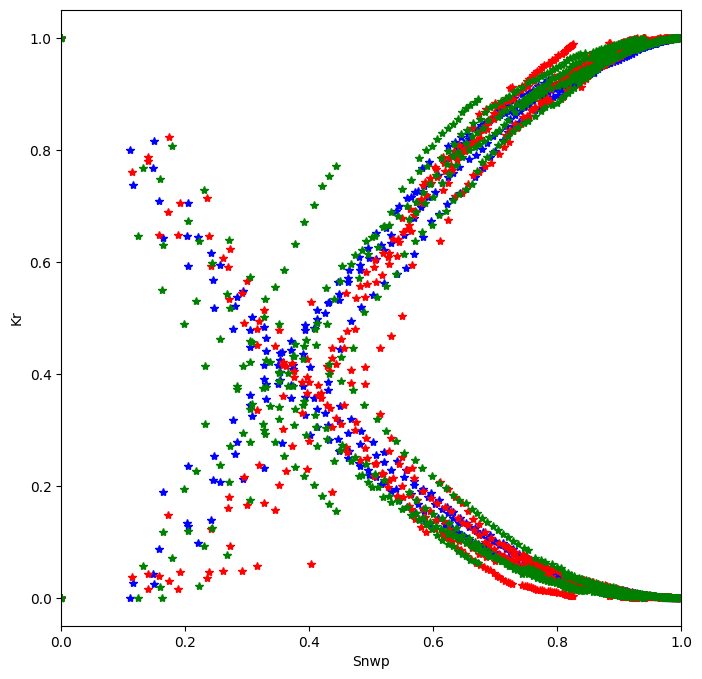

In [18]:
f = plt.figure(figsize=[8,8])
c = ['b*','r*','g*']
for eul,i in zip(kr_phi.keys(),c):
  df_list = kr_phi[eul]
  for j in range(len(df_list)):
    if df_list[j].empty:
      continue
    else:
      plt.plot(df_list[j]['snwp'], df_list[j]['krnw'], i)
      plt.plot(df_list[j]['snwp'], df_list[j]['krw'], i)
plt.xlabel('Snwp')
plt.xlim([0,1])
plt.ylabel('Kr')


#### Check different images - quality of reconstructed Euler vs Euler

The uncertainty is huge

In [20]:
eul = 0
image_num = 100

img_check = []

# initialize inputs for GAN
z = torch.randn(image_num,100)
features = torch.full((image_num,1),eul)

with torch.no_grad():
  fake = gen(z,features)
  img = tensor_process(fake)
  img = img_filter(img)


In [21]:
from skimage.measure import euler_number
def eul(im,conn=3):

    # im: numpy array 
    conn = euler_number(im,connectivity=conn)
    return conn

fake_eul = []
for i in range(img.shape[0]):
    fake_eul.append(eul(img[i,0,::]))

Text(0, 0.5, 'Frequency')

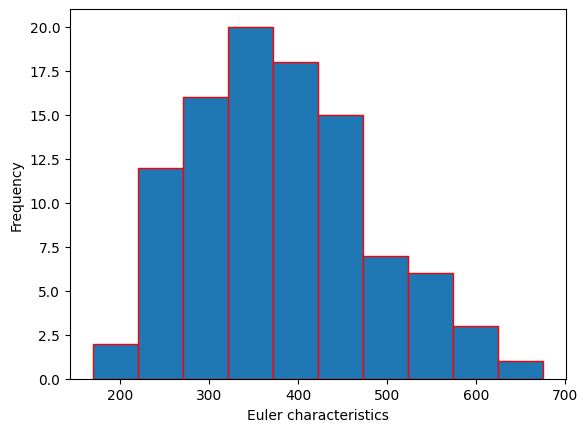

In [22]:
_=plt.hist(fake_eul,edgecolor = 'red')
plt.xlabel('Euler characteristics')
plt.ylabel('Frequency')